In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import geopandas as gpd
import rioxarray as rxr
from rasterio.plot import show
import yaml

# Seabee AI snippet

Detect on bird mission, select a mission with around 50 images

In [2]:
model = "detection/2022_nina_birds_20230817"
root_path = "./nrdata"
input_path = f"/home/notebook/shared-seabee-ns9879k"
mission_name = "oslofjorden_lyseren-zoom_202306271117"
orthophoto_file = f"seabirds/2023/{mission_name}/orthophoto/{mission_name}.tif"

## Create configurations

`hub.yaml` configures the program and paths for the hub. We don't have a gpu on the hub and data is mounted so we can skip minio.

In [3]:
%%bash
mkdir -p config

cat <<EOF >./config/hub.yaml
DPATH_WORK: ./nrdata/work
DPATH_MODELS: /home/notebook/shared-seabee-ns9879k/models
DPATH_RESULTS: ./nrdata/results
DPATH_PRETRAINED: ./nrdata/pretrained
MINIO:
    USE: false
TEST:
    DEVICE: cpu
EOF

`image_detection.yaml` configures the program for training or detection on various images. For the hub we use detection in production mode.

In [4]:
%%bash -s "$model" "$input_path" "$orthophoto_file"

cat <<EOF >./config/image_detection.yaml
mode: production
task: detection
score_threshold: 0.1  # For use in test mode only
model:
    id: $1
dataset:
    root: $2
    # NOTE: Filenames are extracted from the annotation.csv file if annotations are provided, else we use test_filenames
    # NOTE: Using tif's src.descriptions to extract red, green and blue channels
    annotations:
#       csv: None
        crs: "epsg:4326"
        column_main_class: species
        columns_subtasks: [activity,sex,age]
    test_filenames: 
      - $3
EOF

## Run the bird detection

1. preprocess the images

In [5]:
%%bash
nrseabee_det_preproc -c config/hub.yaml -o config/nrseabee_det_preproc.yaml config/image_detection.yaml

Created log file: nrdata/work/dataset/LOG_preprocess.txt
Started: 20231120-153933

 file: /home/notebook/shared-seabee-ns9879k/seabirds/2023/oslofjorden_lyseren-zoom_202306271117/orthophoto/oslofjorden_lyseren-zoom_202306271117.tif
 spatial sample rate: 4.157321079158024 mm x 4.157094088842256 mm
x_res: 0.004157321079158023
y_res: 0.004157094088842256
scale_factor_x: 0.8314642158316047
scale_factor_y: 0.8314188177684512
height: 8577
width: 6746
 original data of shape (8577, 6746) re-sampled to (7131, 5609)
 Doing tile row 1/3
 saving nrdata/work/dataset/images/seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_1_1.jpg and the accompanying .jgw
Save complete
 saving nrdata/work/dataset/images/seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_1_2.jpg and the accompanying .jgw
Save complete
 Doing tile row 2/3
 saving nrdata/work/dataset/images/seabirds_2023_oslofjorden_lyseren_zo

2. start the detection run, (this can take some time)

In [6]:
%%bash

nrseabee_det_test -c config/hub.yaml -o config/nrseabee_det_test.yaml config/nrseabee_det_preproc.yaml

Predictions to be saved in nrdata/results/detection/2022_nina_birds_20230817/2023-11-20-1539
 eta 0.0 minutes | image_id 001 / 6 | seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_1_1.jpg
 eta 1.6 minutes | image_id 002 / 6 | seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_1_2.jpg
 eta 1.6 minutes | image_id 003 / 6 | seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_2_1.jpg
 eta 1.2 minutes | image_id 004 / 6 | seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_2_2.jpg
 eta 0.7 minutes | image_id 005 / 6 | seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_3_1.jpg
 eta -0.0 minutes | image_id 006 / 6 | seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_3_2.jpg


3. generate the geopackage with detections

In [7]:
%%bash -s $mission_name

nrseabee_det_postproc -c config/hub.yaml -o config/$1_postproc.yaml config/nrseabee_det_test.yaml

wrote   nrdata/results/detection/2022_nina_birds_20230817/2023-11-20-1539/out.csv
 .. and nrdata/results/detection/2022_nina_birds_20230817/2023-11-20-1539/out.gpkg


In [8]:
with open(f"config/{mission_name}_postproc.yaml", "r") as f:
    post_conf = yaml.safe_load(f)
post_conf

{'dataset': {'annotations': {'column_main_class': 'species',
   'columns_subtasks': ['activity', 'sex', 'age'],
   'crs': 'epsg:4326'},
  'fn_patch_to_org_filename': ['seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_1_1.jpg::::seabirds/2023/oslofjorden_lyseren-zoom_202306271117/orthophoto/oslofjorden_lyseren-zoom_202306271117.tif',
   'seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_1_2.jpg::::seabirds/2023/oslofjorden_lyseren-zoom_202306271117/orthophoto/oslofjorden_lyseren-zoom_202306271117.tif',
   'seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_2_1.jpg::::seabirds/2023/oslofjorden_lyseren-zoom_202306271117/orthophoto/oslofjorden_lyseren-zoom_202306271117.tif',
   'seabirds_2023_oslofjorden_lyseren_zoom_202306271117_orthophoto_oslofjorden_lyseren_zoom_202306271117_tif_2_2.jpg::::seabirds/2023/oslofjorden_lyseren-z

In [9]:
df_birds =  gpd.read_file(f"{post_conf['dpath_results']}/out.gpkg").to_crs(32632)
df_birds.head()

,id,score_species,score_activity,score_sex,score_age,fileid,individualid,datetimereg,visibleonimage,comment,modelversion,manuallyverified,species,activity,sex,age,TEMP_image_filename,geometry
0,1,0.541986,0.890235,0.532950,0.828448,-1,1,2023-11-20 15:44:35,True,,1,False,2630,2,2,1,seabirds/2023/oslofjorden_lyseren-zoom_2023062...,"POLYGON ((620180.988 6620375.282, 620180.988 6..."
1,2,0.278470,0.652986,0.440584,0.736151,-1,2,2023-11-20 15:44:35,True,,1,False,2630,2,1,1,seabirds/2023/oslofjorden_lyseren-zoom_2023062...,"POLYGON ((620183.068 6620375.405, 620183.068 6..."
2,3,0.253660,0.995814,0.517315,0.996511,-1,3,2023-11-20 15:44:35,True,,1,False,2630,2,1,1,seabirds/2023/oslofjorden_lyseren-zoom_2023062...,"POLYGON ((620182.827 6620377.222, 620182.827 6..."
3,4,0.149589,0.853474,0.549433,0.969612,-1,4,2023-11-20 15:44:35,True,,1,False,2630,4,1,3,seabirds/2023/oslofjorden_lyseren-zoom_2023062...,"POLYGON ((620181.543 6620370.968, 620181.543 6..."
4,5,0.900162,0.828139,0.711931,0.997258,-1,5,2023-11-20 15:44:35,True,,1,False,2630,2,1,3,seabirds/2023/oslofjorden_lyseren-zoom_2023062...,"POLYGON ((620191.364 6620371.088, 620191.364 6..."


In [10]:
raster = rxr.open_rasterio(f"{input_path}/{orthophoto_file}").squeeze()
raster

<xarray.DataArray (band: 3, y: 8577, x: 6746)>
[173581326 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6.202e+05 6.202e+05 ... 6.202e+05 6.202e+05
  * y            (y) float64 6.62e+06 6.62e+06 6.62e+06 ... 6.62e+06 6.62e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('red', 'green', 'blue')

## Plot data

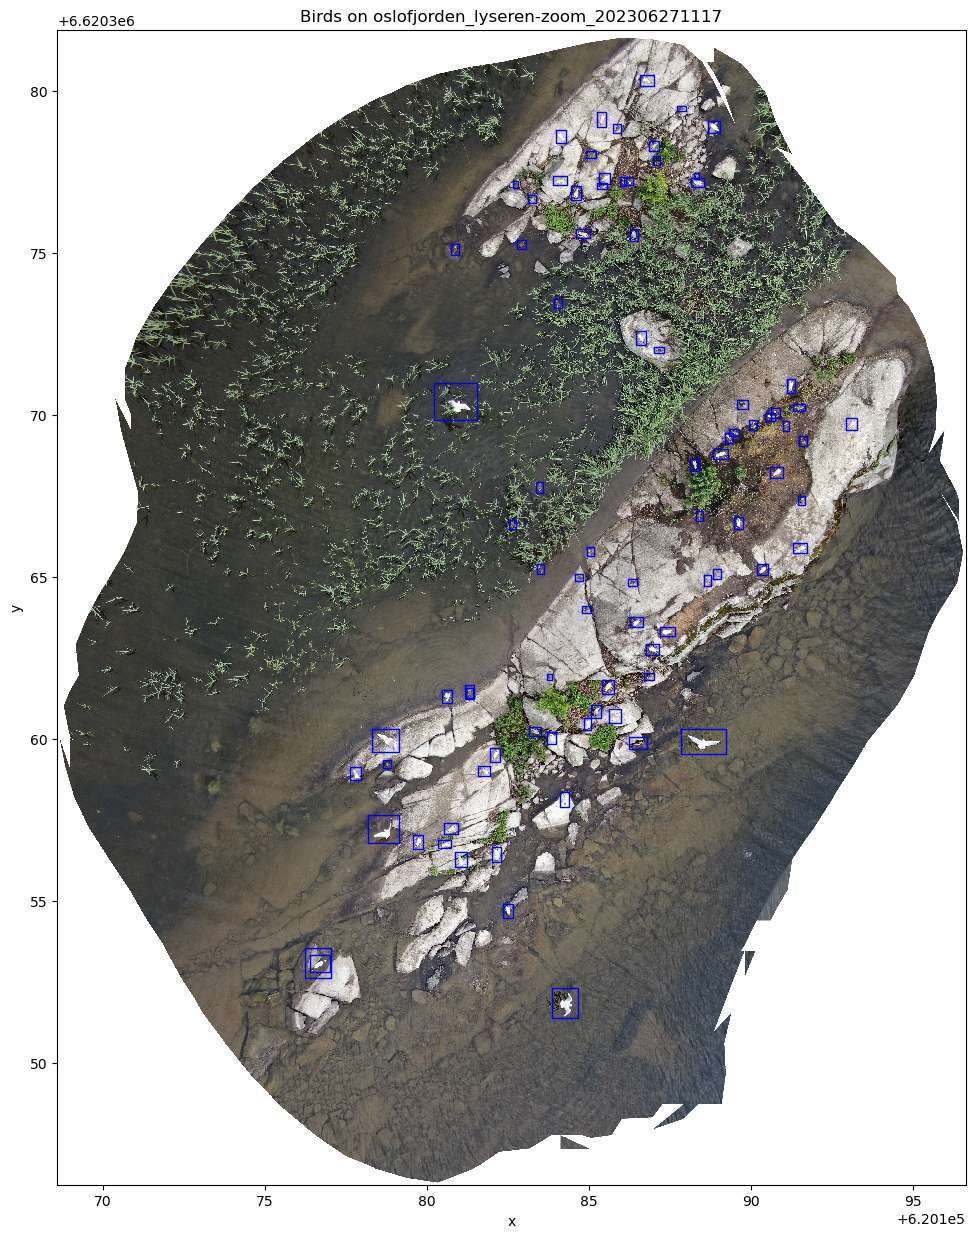

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
bounds = raster.rio.bounds()
extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
raster.plot.imshow(ax=ax, extend=extent)
df_birds.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=1)
plt.title(f"Birds on {mission_name}")
plt.show()